In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.8 MB/s eta 0:00:00


In [13]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

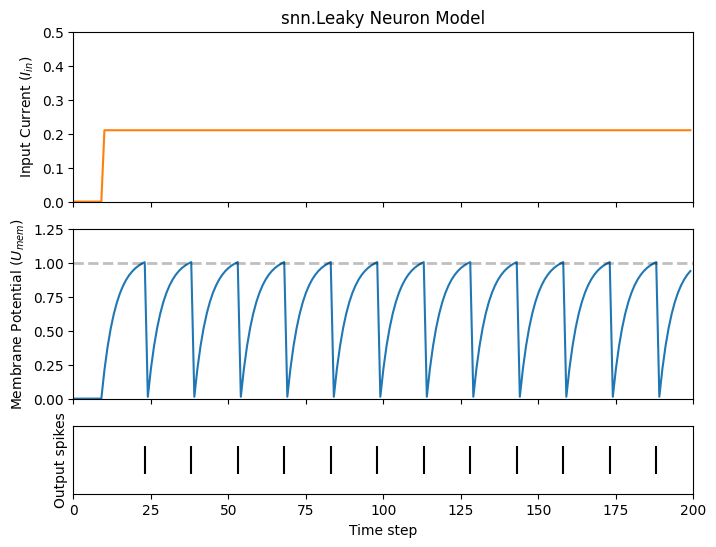

In [6]:
lif1 = snn.Leaky(beta=0.8)

# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
num_steps = 200
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

In [7]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [8]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

In [22]:
# spikegen.latency(torch.rand((1, 784)), num_steps=200).size()
spikegen.rate_conv(torch.rand((200, 784))).size()

torch.Size([200, 784])

In [21]:
spk_in = spikegen.latency(torch.rand((1, 784)), num_steps=200)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


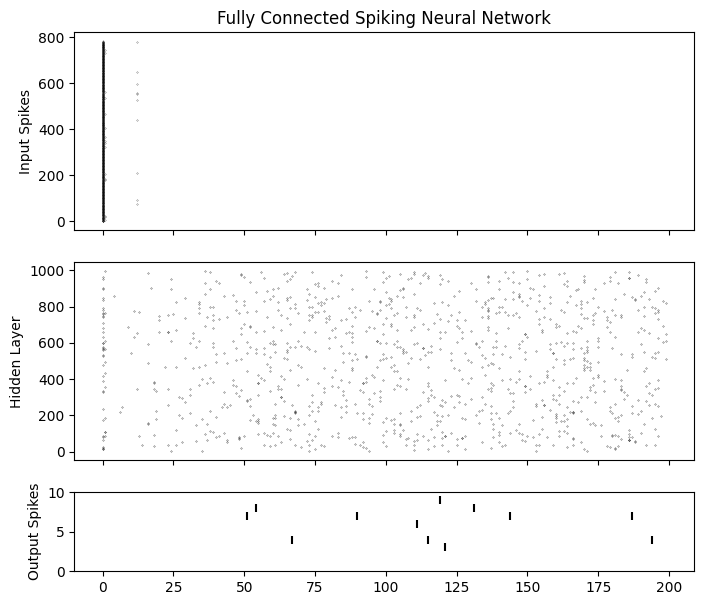

In [23]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

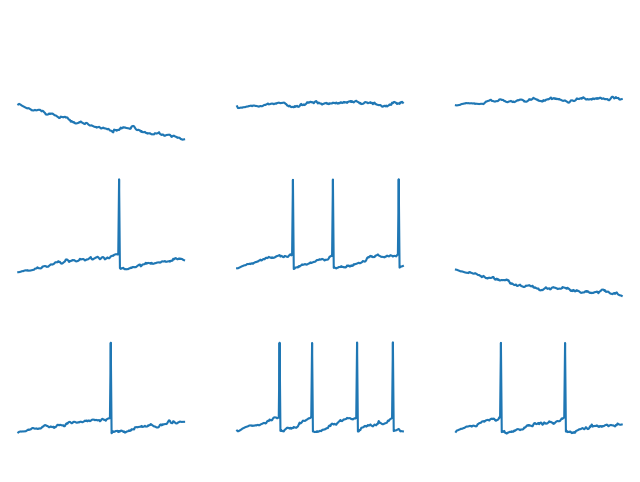

In [24]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)